<a href="https://colab.research.google.com/github/anasmita3/AI_Final/blob/main/Anasmita_AI_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch torchvision tensorboard shap torchsummary

In [ ]:
# ✅ Colab Setup
!pip install shap torchsummary --quiet

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:

# ✅ CIFAR-10 Demo Dataset Loader (for Colab testing)
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

NUM_CLASSES = 10
print("CIFAR-10 demo dataset loaded.")


100%|██████████| 170M/170M [00:01<00:00, 96.0MB/s]


CIFAR-10 demo dataset loaded.


In [ ]:
import os, cv2, gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1IT7pfG0q4VLVtesNqKXZtw9yqn9Ad72- -O archive.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1IT7pfG0q4VLVtesNqKXZtw9yqn9Ad72-
From (redirected): https://drive.google.com/uc?id=1IT7pfG0q4VLVtesNqKXZtw9yqn9Ad72-&confirm=t&uuid=2342606c-b770-4791-8ea4-b366774688a3
To: /content/archive.zip
100% 347M/347M [00:07<00:00, 46.2MB/s]


In [ ]:
import zipfile
import os

zip_path = "archive.zip"
extract_path = "/content/age_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted:", os.listdir(extract_path))

Files extracted: ['utkface_aligned_cropped', 'crop_part1', 'UTKFace']


In [ ]:
import os
print(os.listdir("/content"))

['.config', 'age_dataset', 'data', 'archive.zip', 'drive', 'sample_data']


In [ ]:
import os, cv2, gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Paths
data_dir = "/content/age_dataset/UTKFace"

images, ages, genders = [], [], []

for filename in os.listdir(data_dir):
    try:
        # UTKFace format: age_gender_race_date.jpg
        age, gender, _, _ = filename.split("_", 3)  # skip race
        img_path = os.path.join(data_dir, filename)

        img = cv2.imread(img_path)
        img = cv2.resize(img, (64,64)) / 255.0

        images.append(img)
        ages.append(int(age))
        genders.append(int(gender))  # 0 = male, 1 = female
    except:
        continue

images = np.array(images, dtype="float32")
ages = np.array(ages)
genders = to_categorical(np.array(genders), num_classes=2)

print("✅ Dataset loaded:", images.shape, ages.shape, genders.shape)


✅ Dataset loaded: (23705, 64, 64, 3) (23705,) (23705, 2)


In [ ]:
X_train, X_val, age_train, age_val, gender_train, gender_val = train_test_split(
    images, ages, genders, test_size=0.2, random_state=42
)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the model (moved from a separate cell)
base_model = MobileNetV2(
    input_shape=(64,64,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

# Two heads only
age_output = Dense(1, activation="linear", name="age")(x)          # regression
gender_output = Dense(2, activation="softmax", name="gender")(x)   # classification

model = Model(inputs=base_model.input, outputs=[age_output, gender_output])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss={
        "age": "mse",
        "gender": "categorical_crossentropy"
    },
    metrics={
        "age": ["mae"],
        "gender": ["accuracy"]
    }
)

# model.summary() # Optional: uncomment to see model summary


callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_utkface_model.h5", save_best_only=True, monitor="val_loss")
]

history = model.fit(
    X_train,
    {"age": age_train, "gender": gender_train},   # only 2 heads now
    validation_data=(X_val, {"age": age_val, "gender": gender_val}),
    epochs=20,           # you can increase if Colab doesn't crash
    batch_size=16,       # reduce if you face GPU memory issues
    callbacks=callbacks,
    verbose=1
)

/tmp/ipython-input-3237858373.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - age_loss: 713.2333 - age_mae: 20.9591 - gender_accuracy: 0.6829 - gender_loss: 0.6663 - loss: 713.8997

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 89s 69ms/step - age_loss: 713.0585 - age_mae: 20.9559 - gender_accuracy: 0.6829 - gender_loss: 0.6662 - loss: 713.7249 - val_age_loss: 336.2130 - val_age_mae: 13.7909 - val_gender_accuracy: 0.7762 - val_gender_loss: 0.4836 - val_loss: 336.2233
Epoch 2/20
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - age_loss: 327.2731 - age_mae: 13.6569 - gender_accuracy: 0.7573 - gender_loss: 0.5116 - loss: 327.7849

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 79s 66ms/step - age_loss: 327.2445 - age_mae: 13.6564 - gender_accuracy: 0.7573 - gender_loss: 0.5116 - loss: 327.7562 - val_age_loss: 285.9121 - val_age_mae: 12.7315 - val_gender_accuracy: 0.7714 - val_gender_loss: 0.4844 - val_loss: 286.1483
Epoch 3/20
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - age_loss: 288.1584 - age_mae: 12.9399 - gender_accuracy: 0.7679 - gender_loss: 0.5033 - loss: 288.6617

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 75s 61ms/step - age_loss: 288.1486 - age_mae: 12.9396 - gender_accuracy: 0.7679 - gender_loss: 0.5033 - loss: 288.6520 - val_age_loss: 267.1525 - val_age_mae: 12.3372 - val_gender_accuracy: 0.7840 - val_gender_loss: 0.4702 - val_loss: 267.3994
Epoch 4/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - age_loss: 273.3153 - age_mae: 12.6723 - gender_accuracy: 0.7684 - gender_loss: 0.4939 - loss: 273.8091

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - age_loss: 273.3108 - age_mae: 12.6722 - gender_accuracy: 0.7684 - gender_loss: 0.4939 - loss: 273.8046 - val_age_loss: 255.8966 - val_age_mae: 12.0139 - val_gender_accuracy: 0.7768 - val_gender_loss: 0.4823 - val_loss: 256.1842
Epoch 5/20
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - age_loss: 263.7538 - age_mae: 12.4231 - gender_accuracy: 0.7700 - gender_loss: 0.4914 - loss: 264.2452

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - age_loss: 263.7497 - age_mae: 12.4229 - gender_accuracy: 0.7700 - gender_loss: 0.4914 - loss: 264.2412 - val_age_loss: 248.5719 - val_age_mae: 11.9010 - val_gender_accuracy: 0.7724 - val_gender_loss: 0.4907 - val_loss: 248.8879
Epoch 6/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - age_loss: 253.9775 - age_mae: 12.2361 - gender_accuracy: 0.7773 - gender_loss: 0.4746 - loss: 254.4521

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 83s 68ms/step - age_loss: 253.9779 - age_mae: 12.2361 - gender_accuracy: 0.7773 - gender_loss: 0.4746 - loss: 254.4525 - val_age_loss: 243.8853 - val_age_mae: 11.7911 - val_gender_accuracy: 0.7800 - val_gender_loss: 0.4758 - val_loss: 244.1735
Epoch 7/20
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - age_loss: 252.4113 - age_mae: 12.1620 - gender_accuracy: 0.7682 - gender_loss: 0.4846 - loss: 252.8958

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 75s 62ms/step - age_loss: 252.4121 - age_mae: 12.1621 - gender_accuracy: 0.7682 - gender_loss: 0.4846 - loss: 252.8967 - val_age_loss: 239.9311 - val_age_mae: 11.6517 - val_gender_accuracy: 0.7745 - val_gender_loss: 0.4787 - val_loss: 240.2054
Epoch 8/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - age_loss: 246.2501 - age_mae: 12.0429 - gender_accuracy: 0.7800 - gender_loss: 0.4794 - loss: 246.7291

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - age_loss: 246.2514 - age_mae: 12.0429 - gender_accuracy: 0.7800 - gender_loss: 0.4794 - loss: 246.7301 - val_age_loss: 237.6621 - val_age_mae: 11.6154 - val_gender_accuracy: 0.7747 - val_gender_loss: 0.4761 - val_loss: 237.8990
Epoch 9/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - age_loss: 243.8302 - age_mae: 12.0100 - gender_accuracy: 0.7743 - gender_loss: 0.4797 - loss: 244.3098

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 76s 62ms/step - age_loss: 243.8328 - age_mae: 12.0100 - gender_accuracy: 0.7743 - gender_loss: 0.4797 - loss: 244.3124 - val_age_loss: 235.0607 - val_age_mae: 11.5573 - val_gender_accuracy: 0.7798 - val_gender_loss: 0.4777 - val_loss: 235.3206
Epoch 10/20
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - age_loss: 242.2314 - age_mae: 11.9450 - gender_accuracy: 0.7730 - gender_loss: 0.4855 - loss: 242.7171

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 74s 62ms/step - age_loss: 242.2339 - age_mae: 11.9450 - gender_accuracy: 0.7730 - gender_loss: 0.4855 - loss: 242.7194 - val_age_loss: 234.2790 - val_age_mae: 11.4857 - val_gender_accuracy: 0.7796 - val_gender_loss: 0.4765 - val_loss: 234.5221
Epoch 11/20
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - age_loss: 247.7017 - age_mae: 12.0658 - gender_accuracy: 0.7780 - gender_loss: 0.4882 - loss: 248.1898

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 80s 68ms/step - age_loss: 247.6955 - age_mae: 12.0656 - gender_accuracy: 0.7780 - gender_loss: 0.4882 - loss: 248.1837 - val_age_loss: 232.3969 - val_age_mae: 11.4330 - val_gender_accuracy: 0.7821 - val_gender_loss: 0.4786 - val_loss: 232.6149
Epoch 12/20
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - age_loss: 244.0071 - age_mae: 11.9801 - gender_accuracy: 0.7788 - gender_loss: 0.4892 - loss: 244.4963

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - age_loss: 244.0026 - age_mae: 11.9800 - gender_accuracy: 0.7788 - gender_loss: 0.4892 - loss: 244.4918 - val_age_loss: 230.4109 - val_age_mae: 11.4313 - val_gender_accuracy: 0.7768 - val_gender_loss: 0.4737 - val_loss: 230.6217
Epoch 13/20
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - age_loss: 242.2694 - age_mae: 11.9366 - gender_accuracy: 0.7702 - gender_loss: 0.4848 - loss: 242.7541

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 81s 68ms/step - age_loss: 242.2659 - age_mae: 11.9365 - gender_accuracy: 0.7702 - gender_loss: 0.4848 - loss: 242.7507 - val_age_loss: 229.4316 - val_age_mae: 11.3729 - val_gender_accuracy: 0.7861 - val_gender_loss: 0.4699 - val_loss: 229.6541
Epoch 14/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - age_loss: 242.6308 - age_mae: 11.9514 - gender_accuracy: 0.7786 - gender_loss: 0.4783 - loss: 243.1091

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 73s 61ms/step - age_loss: 242.6268 - age_mae: 11.9513 - gender_accuracy: 0.7786 - gender_loss: 0.4783 - loss: 243.1051 - val_age_loss: 228.8370 - val_age_mae: 11.3585 - val_gender_accuracy: 0.7882 - val_gender_loss: 0.4699 - val_loss: 229.0631
Epoch 15/20
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - age_loss: 238.4261 - age_mae: 11.8251 - gender_accuracy: 0.7690 - gender_loss: 0.4933 - loss: 238.9193

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 83s 62ms/step - age_loss: 238.4245 - age_mae: 11.8251 - gender_accuracy: 0.7690 - gender_loss: 0.4933 - loss: 238.9179 - val_age_loss: 227.8306 - val_age_mae: 11.3045 - val_gender_accuracy: 0.7804 - val_gender_loss: 0.4800 - val_loss: 228.0592
Epoch 16/20
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - age_loss: 238.7405 - age_mae: 11.8509 - gender_accuracy: 0.7741 - gender_loss: 0.4882 - loss: 239.2286

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 90s 69ms/step - age_loss: 238.7366 - age_mae: 11.8508 - gender_accuracy: 0.7741 - gender_loss: 0.4882 - loss: 239.2250 - val_age_loss: 226.5716 - val_age_mae: 11.3614 - val_gender_accuracy: 0.7690 - val_gender_loss: 0.4932 - val_loss: 226.8319
Epoch 17/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - age_loss: 238.2342 - age_mae: 11.7769 - gender_accuracy: 0.7763 - gender_loss: 0.4852 - loss: 238.7193

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 72s 60ms/step - age_loss: 238.2320 - age_mae: 11.7769 - gender_accuracy: 0.7763 - gender_loss: 0.4852 - loss: 238.7172 - val_age_loss: 225.6401 - val_age_mae: 11.2663 - val_gender_accuracy: 0.7819 - val_gender_loss: 0.4754 - val_loss: 225.8722
Epoch 18/20
1185/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - age_loss: 232.2877 - age_mae: 11.6617 - gender_accuracy: 0.7690 - gender_loss: 0.4936 - loss: 232.7813

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - age_loss: 232.2915 - age_mae: 11.6619 - gender_accuracy: 0.7690 - gender_loss: 0.4936 - loss: 232.7852 - val_age_loss: 225.2790 - val_age_mae: 11.2610 - val_gender_accuracy: 0.7813 - val_gender_loss: 0.4704 - val_loss: 225.4985
Epoch 19/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - age_loss: 238.6273 - age_mae: 11.8513 - gender_accuracy: 0.7686 - gender_loss: 0.4937 - loss: 239.1210

1186/1186 ━━━━━━━━━━━━━━━━━━━━ 89s 66ms/step - age_loss: 238.6250 - age_mae: 11.8512 - gender_accuracy: 0.7686 - gender_loss: 0.4937 - loss: 239.1188 - val_age_loss: 224.5480 - val_age_mae: 11.2757 - val_gender_accuracy: 0.7638 - val_gender_loss: 0.5033 - val_loss: 224.7814
Epoch 20/20
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - age_loss: 234.0759 - age_mae: 11.7626 - gender_accuracy: 0.7733 - gender_loss: 0.4832 - loss: 234.5592 - val_age_loss: 225.4976 - val_age_mae: 11.2079 - val_gender_accuracy: 0.7792 - val_gender_loss: 0.4711 - val_loss: 225.7040


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(
    input_shape=(64,64,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

# Two heads only
age_output = Dense(1, activation="linear", name="age")(x)          # regression
gender_output = Dense(2, activation="softmax", name="gender")(x)   # classification

model = Model(inputs=base_model.input, outputs=[age_output, gender_output])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss={
        "age": "mse",
        "gender": "categorical_crossentropy"
    },
    metrics={
        "age": ["mae"],
        "gender": ["accuracy"]
    }
)

model.summary()

/tmp/ipython-input-4255288529.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("mobilenetv2_utkface.h5", save_best_only=True, monitor="val_loss")
]

history = model.fit(
    X_train,
    {"age": age_train, "gender": gender_train},
    validation_data=(X_val, {"age": age_val, "gender": gender_val}),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - age_loss: 809.4904 - age_mae: 22.5057 - gender_accuracy: 0.6458 - gender_loss: 0.7360 - loss: 810.2269

593/593 ━━━━━━━━━━━━━━━━━━━━ 80s 126ms/step - age_loss: 809.1254 - age_mae: 22.4994 - gender_accuracy: 0.6459 - gender_loss: 0.7358 - loss: 809.8622 - val_age_loss: 400.8490 - val_age_mae: 15.1095 - val_gender_accuracy: 0.7623 - val_gender_loss: 0.5033 - val_loss: 399.5456
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - age_loss: 374.6550 - age_mae: 14.6640 - gender_accuracy: 0.7515 - gender_loss: 0.5197 - loss: 375.1748

593/593 ━━━━━━━━━━━━━━━━━━━━ 72s 121ms/step - age_loss: 374.6166 - age_mae: 14.6632 - gender_accuracy: 0.7515 - gender_loss: 0.5197 - loss: 375.1365 - val_age_loss: 320.6264 - val_age_mae: 13.4367 - val_gender_accuracy: 0.7792 - val_gender_loss: 0.4741 - val_loss: 320.1141
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - age_loss: 316.6403 - age_mae: 13.5312 - gender_accuracy: 0.7664 - gender_loss: 0.4847 - loss: 317.1250

593/593 ━━━━━━━━━━━━━━━━━━━━ 73s 107ms/step - age_loss: 316.6274 - age_mae: 13.5308 - gender_accuracy: 0.7664 - gender_loss: 0.4847 - loss: 317.1123 - val_age_loss: 291.2549 - val_age_mae: 12.7947 - val_gender_accuracy: 0.7541 - val_gender_loss: 0.4977 - val_loss: 291.0815
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - age_loss: 289.7988 - age_mae: 12.9736 - gender_accuracy: 0.7656 - gender_loss: 0.4919 - loss: 290.2906

593/593 ━━━━━━━━━━━━━━━━━━━━ 72s 121ms/step - age_loss: 289.7942 - age_mae: 12.9735 - gender_accuracy: 0.7656 - gender_loss: 0.4918 - loss: 290.2861 - val_age_loss: 275.4919 - val_age_mae: 12.4250 - val_gender_accuracy: 0.7825 - val_gender_loss: 0.4639 - val_loss: 275.3854
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - age_loss: 271.9661 - age_mae: 12.6010 - gender_accuracy: 0.7795 - gender_loss: 0.4776 - loss: 272.4438

593/593 ━━━━━━━━━━━━━━━━━━━━ 74s 108ms/step - age_loss: 271.9733 - age_mae: 12.6011 - gender_accuracy: 0.7795 - gender_loss: 0.4776 - loss: 272.4511 - val_age_loss: 265.2029 - val_age_mae: 12.2890 - val_gender_accuracy: 0.7815 - val_gender_loss: 0.4599 - val_loss: 265.1603
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - age_loss: 273.7043 - age_mae: 12.6001 - gender_accuracy: 0.7780 - gender_loss: 0.4685 - loss: 274.1729

593/593 ━━━━━━━━━━━━━━━━━━━━ 91s 124ms/step - age_loss: 273.6910 - age_mae: 12.5998 - gender_accuracy: 0.7780 - gender_loss: 0.4685 - loss: 274.1598 - val_age_loss: 257.4553 - val_age_mae: 12.0633 - val_gender_accuracy: 0.7817 - val_gender_loss: 0.4709 - val_loss: 257.4148
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - age_loss: 262.3058 - age_mae: 12.3374 - gender_accuracy: 0.7838 - gender_loss: 0.4725 - loss: 262.7785

593/593 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - age_loss: 262.3039 - age_mae: 12.3374 - gender_accuracy: 0.7837 - gender_loss: 0.4725 - loss: 262.7767 - val_age_loss: 251.8547 - val_age_mae: 11.9424 - val_gender_accuracy: 0.7718 - val_gender_loss: 0.4704 - val_loss: 251.8084
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - age_loss: 250.6652 - age_mae: 12.1357 - gender_accuracy: 0.7750 - gender_loss: 0.4772 - loss: 251.1427

593/593 ━━━━━━━━━━━━━━━━━━━━ 74s 109ms/step - age_loss: 250.6751 - age_mae: 12.1359 - gender_accuracy: 0.7750 - gender_loss: 0.4772 - loss: 251.1527 - val_age_loss: 247.3877 - val_age_mae: 11.8517 - val_gender_accuracy: 0.7676 - val_gender_loss: 0.4825 - val_loss: 247.3400
Epoch 9/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - age_loss: 254.1537 - age_mae: 12.2704 - gender_accuracy: 0.7778 - gender_loss: 0.4765 - loss: 254.6302

593/593 ━━━━━━━━━━━━━━━━━━━━ 92s 126ms/step - age_loss: 254.1553 - age_mae: 12.2703 - gender_accuracy: 0.7778 - gender_loss: 0.4765 - loss: 254.6319 - val_age_loss: 244.4284 - val_age_mae: 11.7236 - val_gender_accuracy: 0.7787 - val_gender_loss: 0.4685 - val_loss: 244.3966
Epoch 10/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - age_loss: 248.7519 - age_mae: 12.0765 - gender_accuracy: 0.7833 - gender_loss: 0.4716 - loss: 249.2233

593/593 ━━━━━━━━━━━━━━━━━━━━ 72s 121ms/step - age_loss: 248.7540 - age_mae: 12.0766 - gender_accuracy: 0.7832 - gender_loss: 0.4716 - loss: 249.2252 - val_age_loss: 241.7981 - val_age_mae: 11.6846 - val_gender_accuracy: 0.7832 - val_gender_loss: 0.4695 - val_loss: 241.6964
Epoch 11/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - age_loss: 245.9805 - age_mae: 12.0140 - gender_accuracy: 0.7776 - gender_loss: 0.4777 - loss: 246.4582

593/593 ━━━━━━━━━━━━━━━━━━━━ 74s 124ms/step - age_loss: 245.9846 - age_mae: 12.0141 - gender_accuracy: 0.7776 - gender_loss: 0.4777 - loss: 246.4624 - val_age_loss: 239.4937 - val_age_mae: 11.6563 - val_gender_accuracy: 0.7779 - val_gender_loss: 0.4664 - val_loss: 239.3860
Epoch 12/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - age_loss: 245.0961 - age_mae: 12.0358 - gender_accuracy: 0.7789 - gender_loss: 0.4768 - loss: 245.5728

593/593 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - age_loss: 245.0997 - age_mae: 12.0358 - gender_accuracy: 0.7789 - gender_loss: 0.4768 - loss: 245.5763 - val_age_loss: 237.5977 - val_age_mae: 11.5908 - val_gender_accuracy: 0.7817 - val_gender_loss: 0.4639 - val_loss: 237.4715
Epoch 13/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - age_loss: 243.8246 - age_mae: 11.9394 - gender_accuracy: 0.7761 - gender_loss: 0.4720 - loss: 244.2965

593/593 ━━━━━━━━━━━━━━━━━━━━ 74s 125ms/step - age_loss: 243.8293 - age_mae: 11.9396 - gender_accuracy: 0.7761 - gender_loss: 0.4720 - loss: 244.3013 - val_age_loss: 236.0721 - val_age_mae: 11.5295 - val_gender_accuracy: 0.7794 - val_gender_loss: 0.4664 - val_loss: 235.9152
Epoch 14/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - age_loss: 249.2949 - age_mae: 12.1600 - gender_accuracy: 0.7798 - gender_loss: 0.4798 - loss: 249.7747

593/593 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - age_loss: 249.2895 - age_mae: 12.1598 - gender_accuracy: 0.7798 - gender_loss: 0.4798 - loss: 249.7692 - val_age_loss: 234.6953 - val_age_mae: 11.5357 - val_gender_accuracy: 0.7834 - val_gender_loss: 0.4706 - val_loss: 234.5214
Epoch 15/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - age_loss: 240.9758 - age_mae: 11.9349 - gender_accuracy: 0.7773 - gender_loss: 0.4800 - loss: 241.4557

593/593 ━━━━━━━━━━━━━━━━━━━━ 74s 111ms/step - age_loss: 240.9829 - age_mae: 11.9351 - gender_accuracy: 0.7773 - gender_loss: 0.4800 - loss: 241.4626 - val_age_loss: 233.1811 - val_age_mae: 11.4845 - val_gender_accuracy: 0.7777 - val_gender_loss: 0.4683 - val_loss: 233.0142
Epoch 16/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - age_loss: 241.2677 - age_mae: 11.8985 - gender_accuracy: 0.7737 - gender_loss: 0.4835 - loss: 241.7510

593/593 ━━━━━━━━━━━━━━━━━━━━ 93s 129ms/step - age_loss: 241.2673 - age_mae: 11.8985 - gender_accuracy: 0.7737 - gender_loss: 0.4835 - loss: 241.7506 - val_age_loss: 232.6898 - val_age_mae: 11.4395 - val_gender_accuracy: 0.7849 - val_gender_loss: 0.4622 - val_loss: 232.4462
Epoch 17/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - age_loss: 239.6599 - age_mae: 11.8981 - gender_accuracy: 0.7806 - gender_loss: 0.4735 - loss: 240.1335

593/593 ━━━━━━━━━━━━━━━━━━━━ 79s 124ms/step - age_loss: 239.6644 - age_mae: 11.8982 - gender_accuracy: 0.7806 - gender_loss: 0.4735 - loss: 240.1380 - val_age_loss: 231.6726 - val_age_mae: 11.4956 - val_gender_accuracy: 0.7813 - val_gender_loss: 0.4681 - val_loss: 231.5205
Epoch 18/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - age_loss: 239.9606 - age_mae: 11.8524 - gender_accuracy: 0.7738 - gender_loss: 0.4752 - loss: 240.4357

593/593 ━━━━━━━━━━━━━━━━━━━━ 83s 125ms/step - age_loss: 239.9602 - age_mae: 11.8524 - gender_accuracy: 0.7738 - gender_loss: 0.4752 - loss: 240.4353 - val_age_loss: 230.4783 - val_age_mae: 11.4312 - val_gender_accuracy: 0.7773 - val_gender_loss: 0.4748 - val_loss: 230.3631
Epoch 19/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - age_loss: 235.8878 - age_mae: 11.8575 - gender_accuracy: 0.7799 - gender_loss: 0.4696 - loss: 236.3574

593/593 ━━━━━━━━━━━━━━━━━━━━ 76s 128ms/step - age_loss: 235.8938 - age_mae: 11.8575 - gender_accuracy: 0.7799 - gender_loss: 0.4696 - loss: 236.3634 - val_age_loss: 230.2053 - val_age_mae: 11.3686 - val_gender_accuracy: 0.7775 - val_gender_loss: 0.4729 - val_loss: 230.0130
Epoch 20/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - age_loss: 240.4442 - age_mae: 11.9292 - gender_accuracy: 0.7814 - gender_loss: 0.4803 - loss: 240.9243

593/593 ━━━━━━━━━━━━━━━━━━━━ 64s 108ms/step - age_loss: 240.4460 - age_mae: 11.9292 - gender_accuracy: 0.7814 - gender_loss: 0.4803 - loss: 240.9259 - val_age_loss: 228.9038 - val_age_mae: 11.3317 - val_gender_accuracy: 0.7811 - val_gender_loss: 0.4704 - val_loss: 228.7577


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


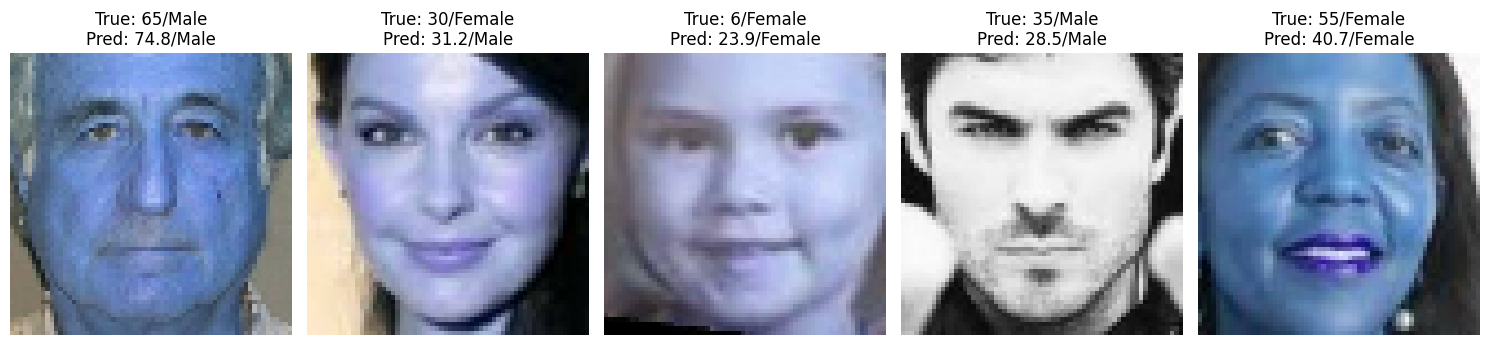

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Select multiple random images from the validation set
num_images_to_test = 5  # You can change this number
random_indices = random.sample(range(len(X_val)), num_images_to_test)

gender_labels = ["Male", "Female"]

plt.figure(figsize=(15, 5)) # Adjust figure size as needed

for i, random_index in enumerate(random_indices):
    random_image = X_val[random_index]
    true_age = age_val[random_index]
    true_gender = gender_val[random_index] # This is one-hot encoded

    # Reshape image for prediction (add batch dimension)
    image_for_prediction = np.expand_dims(random_image, axis=0)

    # Make a prediction
    predictions = model.predict(image_for_prediction)
    predicted_age = predictions[0][0][0]
    predicted_gender_probs = predictions[1][0]
    predicted_gender = np.argmax(predicted_gender_probs)

    # Convert true gender from one-hot encoding to integer
    true_gender_int = np.argmax(true_gender)

    # Display the image and predictions
    plt.subplot(1, num_images_to_test, i + 1)
    plt.imshow(random_image)
    plt.title(f"True: {true_age}/{gender_labels[true_gender_int]}\nPred: {predicted_age:.1f}/{gender_labels[predicted_gender]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report
import tensorflow as tf

# Make predictions on the entire validation set
# Use model.predict for Keras models
predictions_val = model.predict(X_val)

# predictions_val will be a list containing the predictions for each output head
predicted_age_val = predictions_val[0].flatten()
predicted_gender_probs_val = predictions_val[1]
predicted_gender_val = np.argmax(predicted_gender_probs_val, axis=1)

# Calculate Age MAE
mae_age = mean_absolute_error(age_val, predicted_age_val)

# Calculate Gender Accuracy
# Assuming gender_val is one-hot encoded, convert it to class indices
true_gender_val_indices = np.argmax(gender_val, axis=1)
accuracy_gender = accuracy_score(true_gender_val_indices, predicted_gender_val)

# Print Metrics
print("\nModel Evaluation Metrics:")
print(f"  Age MAE on Validation Set: {mae_age:.2f}")
print(f"  Gender Accuracy on Validation Set: {accuracy_gender:.4f}")

# Optional: Print Classification Report for Gender
print("\nGender Classification Report:")
print(classification_report(true_gender_val_indices, predicted_gender_val, target_names=["Male", "Female"]))

# You can also use model.evaluate for overall loss and metrics
# evaluation_results = model.evaluate(X_val, {"age": age_val, "gender": gender_val}, verbose=0)
# print("\nOverall Evaluation Results (from model.evaluate):")
# for metric_name, metric_value in zip(model.metrics_names, evaluation_results):
#     print(f"  {metric_name}: {metric_value:.4f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step

Model Evaluation Metrics:
  Age MAE on Validation Set: 11.33
  Gender Accuracy on Validation Set: 0.7811

Gender Classification Report:
              precision    recall  f1-score   support

        Male       0.76      0.84      0.80      2447
      Female       0.81      0.72      0.76      2294

    accuracy                           0.78      4741
   macro avg       0.78      0.78      0.78      4741
weighted avg       0.78      0.78      0.78      4741



75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step


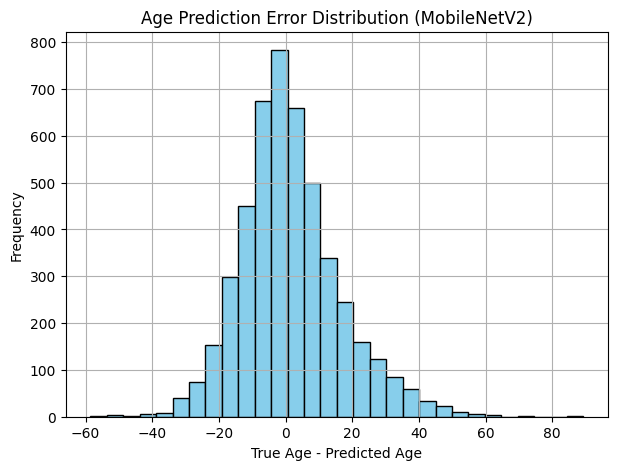

In [ ]:
# Predict on validation set
pred_age, _ = model.predict(X_val, batch_size=64)
age_errors = age_val - pred_age.squeeze()

plt.figure(figsize=(7,5))
plt.hist(age_errors, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("True Age - Predicted Age")
plt.ylabel("Frequency")
plt.title("Age Prediction Error Distribution (MobileNetV2)")
plt.grid(True)
plt.show()


Hybrid Neural Network Model

In [ ]:
# Cell A: Simple SSM Layer for Colab, fallback if keras_nlp LAYERS not found
from tensorflow.keras.layers import Layer

class SSMBlock(Layer):
    def __init__(self, filters, **kwargs):
        super(SSMBlock, self).__init__(**kwargs)
        self.filters = filters
        self.dense1 = Dense(filters, activation='relu')
        self.dense2 = Dense(filters, activation='sigmoid')
    def call(self, x):
        attn = self.dense2(x)
        state = self.dense1(x)
        return attn * state + (1.0 - attn) * x


In [ ]:
# Cell B: Build custom hybrid model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization, GlobalAveragePooling2D, Multiply, Add, Softmax, Reshape, Permute, Lambda
from tensorflow.keras.models import Model

def HybridAttentionCNNSSM(input_shape=(64,64,3)):
    inputs = Input(shape=input_shape)

    # Initial CNN Block
    x = Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    # Second CNN Block
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    # Third CNN Block
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    # Attention Layer (Squeeze-and-Excitation Style)
    attn = GlobalAveragePooling2D()(x)
    attn = Dense(32, activation='relu')(attn)
    attn = Dense(128, activation='sigmoid')(attn)
    attn = Reshape((1,1,128))(attn)
    x = Multiply()([x, attn])

    # SSM Block (1D over channels for simplicity)
    ssm = SSMBlock(128)
    x = ssm(x)

    # Head
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    age_output = Dense(1, activation='linear', name='age')(x)
    gender_output = Dense(2, activation='softmax', name='gender')(x)
    model = Model(inputs=inputs, outputs=[age_output, gender_output])
    return model

In [ ]:
# Cell C: Create and compile the model
hybrid_model = HybridAttentionCNNSSM(input_shape=(64,64,3))
hybrid_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'age': 'mse', 'gender': 'categorical_crossentropy'},
    metrics={'age': ['mae'], 'gender': ['accuracy']}
)
hybrid_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      4,224 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 8, 8, 128) │          0 │ max_pooling2d_2[… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ssm_block           │ (None, 8, 8, 128) │     33,024 │ multiply[0][0]    │
│ (SSMBlock)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ ssm_block[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ global_average_p

 Total params: 135,907 (530.89 KB)

 Trainable params: 135,459 (529.14 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Cell D: Train with same callbacks as before
hybrid_history = hybrid_model.fit(
    X_train,
    {"age": age_train, "gender": gender_train},
    validation_data=(X_val, {"age": age_val, "gender": gender_val}),
    epochs=20,
    batch_size=32,  # Lower if Colab RAM issues
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 247s 407ms/step - age_loss: 478.4693 - age_mae: 16.3171 - gender_accuracy: 0.5320 - gender_loss: 1.0136 - loss: 479.4829 - val_age_loss: 284.0684 - val_age_mae: 13.7452 - val_gender_accuracy: 0.5201 - val_gender_loss: 0.7755 - val_loss: 284.9125
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 265s 412ms/step - age_loss: 180.2354 - age_mae: 10.1032 - gender_accuracy: 0.6008 - gender_loss: 0.6732 - loss: 180.9086 - val_age_loss: 4648.9136 - val_age_mae: 63.9744 - val_gender_accuracy: 0.6233 - val_gender_loss: 0.6460 - val_loss: 4657.5552
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 273s 430ms/step - age_loss: 138.1848 - age_mae: 8.7759 - gender_accuracy: 0.6217 - gender_loss: 0.6532 - loss: 138.8380 - val_age_loss: 285.0854 - val_age_mae: 12.3971 - val_gender_accuracy: 0.6914 - val_gender_loss: 0.6181 - val_loss: 284.4256
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - age_loss: 119.4618 - age_mae: 8.1391 - gender_accuracy: 0.6304 - gender_loss: 0.6445 

593/593 ━━━━━━━━━━━━━━━━━━━━ 257s 433ms/step - age_loss: 119.4620 - age_mae: 8.1391 - gender_accuracy: 0.6304 - gender_loss: 0.6445 - loss: 120.1065 - val_age_loss: 209.6605 - val_age_mae: 10.9663 - val_gender_accuracy: 0.6170 - val_gender_loss: 0.6470 - val_loss: 210.0160
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - age_loss: 116.2350 - age_mae: 7.9393 - gender_accuracy: 0.6356 - gender_loss: 0.6431 - loss: 116.8782

593/593 ━━━━━━━━━━━━━━━━━━━━ 257s 424ms/step - age_loss: 116.2253 - age_mae: 7.9389 - gender_accuracy: 0.6356 - gender_loss: 0.6431 - loss: 116.8685 - val_age_loss: 150.4375 - val_age_mae: 9.4023 - val_gender_accuracy: 0.6705 - val_gender_loss: 0.6149 - val_loss: 150.6336
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 259s 420ms/step - age_loss: 94.9629 - age_mae: 7.1515 - gender_accuracy: 0.6559 - gender_loss: 0.6217 - loss: 95.5846 - val_age_loss: 157.4903 - val_age_mae: 8.9645 - val_gender_accuracy: 0.6399 - val_gender_loss: 0.6381 - val_loss: 157.6995
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 240s 405ms/step - age_loss: 88.3584 - age_mae: 6.9043 - gender_accuracy: 0.6587 - gender_loss: 0.6240 - loss: 88.9823 - val_age_loss: 464.8914 - val_age_mae: 16.8920 - val_gender_accuracy: 0.6368 - val_gender_loss: 0.6285 - val_loss: 467.0146
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 272s 422ms/step - age_loss: 83.3808 - age_mae: 6.6770 - gender_accuracy: 0.6608 - gender_loss: 0.6175 - loss: 83.9980 - va

593/593 ━━━━━━━━━━━━━━━━━━━━ 251s 424ms/step - age_loss: 70.5199 - age_mae: 6.1518 - gender_accuracy: 0.6877 - gender_loss: 0.5882 - loss: 71.1081 - val_age_loss: 127.9471 - val_age_mae: 8.6606 - val_gender_accuracy: 0.7081 - val_gender_loss: 0.5631 - val_loss: 127.8560
Epoch 11/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - age_loss: 71.6329 - age_mae: 6.1751 - gender_accuracy: 0.6895 - gender_loss: 0.5881 - loss: 72.2210

593/593 ━━━━━━━━━━━━━━━━━━━━ 251s 406ms/step - age_loss: 71.6381 - age_mae: 6.1753 - gender_accuracy: 0.6895 - gender_loss: 0.5881 - loss: 72.2262 - val_age_loss: 105.7896 - val_age_mae: 7.2880 - val_gender_accuracy: 0.7298 - val_gender_loss: 0.5436 - val_loss: 105.9922
Epoch 12/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 269s 418ms/step - age_loss: 65.6560 - age_mae: 5.9284 - gender_accuracy: 0.7099 - gender_loss: 0.5683 - loss: 66.2243 - val_age_loss: 147.4898 - val_age_mae: 8.7120 - val_gender_accuracy: 0.7241 - val_gender_loss: 0.5589 - val_loss: 148.4157
Epoch 13/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 260s 415ms/step - age_loss: 62.3936 - age_mae: 5.7993 - gender_accuracy: 0.7101 - gender_loss: 0.5553 - loss: 62.9489 - val_age_loss: 117.5184 - val_age_mae: 7.4632 - val_gender_accuracy: 0.6855 - val_gender_loss: 0.5887 - val_loss: 117.6145
Epoch 14/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - age_loss: 61.8320 - age_mae: 5.7486 - gender_accuracy: 0.7296 - gender_loss: 0.5371 - loss: 62.3691

593/593 ━━━━━━━━━━━━━━━━━━━━ 264s 418ms/step - age_loss: 61.8318 - age_mae: 5.7486 - gender_accuracy: 0.7296 - gender_loss: 0.5371 - loss: 62.3689 - val_age_loss: 96.8493 - val_age_mae: 6.9528 - val_gender_accuracy: 0.7576 - val_gender_loss: 0.4992 - val_loss: 97.0970
Epoch 15/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 264s 420ms/step - age_loss: 56.2674 - age_mae: 5.5155 - gender_accuracy: 0.7378 - gender_loss: 0.5216 - loss: 56.7889 - val_age_loss: 103.6229 - val_age_mae: 7.1708 - val_gender_accuracy: 0.7378 - val_gender_loss: 0.5215 - val_loss: 104.1551
Epoch 16/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 264s 424ms/step - age_loss: 53.7797 - age_mae: 5.3588 - gender_accuracy: 0.7454 - gender_loss: 0.5143 - loss: 54.2939 - val_age_loss: 279.8123 - val_age_mae: 12.2237 - val_gender_accuracy: 0.7585 - val_gender_loss: 0.4930 - val_loss: 280.3448
Epoch 17/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 253s 427ms/step - age_loss: 51.7724 - age_mae: 5.3451 - gender_accuracy: 0.7436 - gender_loss: 0.5015 - loss: 52.2740 - val

593/593 ━━━━━━━━━━━━━━━━━━━━ 256s 417ms/step - age_loss: 46.5544 - age_mae: 5.0663 - gender_accuracy: 0.7582 - gender_loss: 0.4942 - loss: 47.0486 - val_age_loss: 93.8086 - val_age_mae: 6.8131 - val_gender_accuracy: 0.7787 - val_gender_loss: 0.4629 - val_loss: 94.1812
Epoch 19/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 248s 418ms/step - age_loss: 45.6903 - age_mae: 5.0246 - gender_accuracy: 0.7621 - gender_loss: 0.4878 - loss: 46.1781 - val_age_loss: 115.2053 - val_age_mae: 7.3755 - val_gender_accuracy: 0.7865 - val_gender_loss: 0.4584 - val_loss: 115.7691
Epoch 20/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 263s 419ms/step - age_loss: 44.0979 - age_mae: 4.8693 - gender_accuracy: 0.7535 - gender_loss: 0.4920 - loss: 44.5899 - val_age_loss: 113.1432 - val_age_mae: 7.3090 - val_gender_accuracy: 0.7802 - val_gender_loss: 0.4555 - val_loss: 113.8207


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


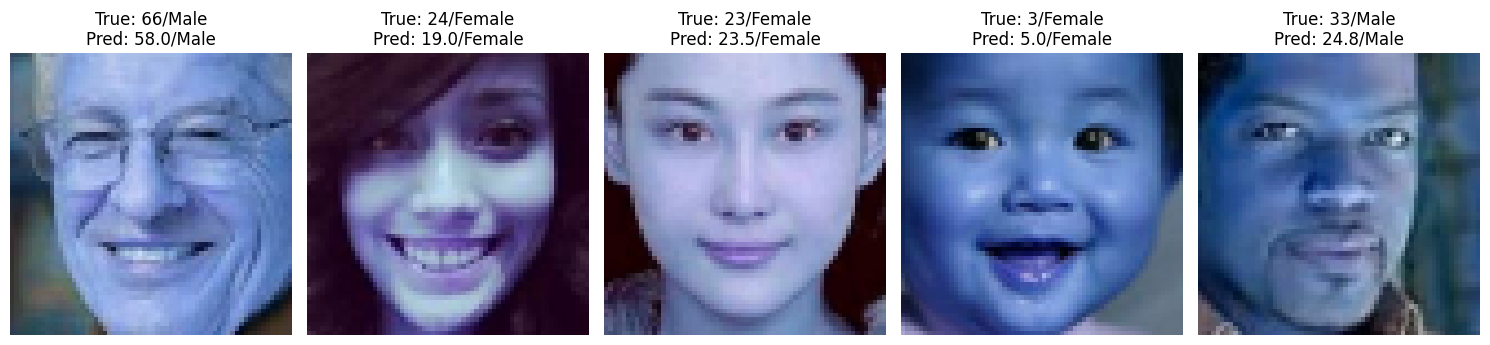

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Select multiple random images from the validation set
num_images_to_test = 5  # You can change this number
random_indices = random.sample(range(len(X_val)), num_images_to_test)

gender_labels = ["Male", "Female"]

plt.figure(figsize=(15, 5)) # Adjust figure size as needed

for i, random_index in enumerate(random_indices):
    random_image = X_val[random_index]
    true_age = age_val[random_index]
    true_gender = gender_val[random_index] # This is one-hot encoded

    # Reshape image for prediction (add batch dimension)
    image_for_prediction = np.expand_dims(random_image, axis=0)

    # Make a prediction using the hybrid model
    predictions = hybrid_model.predict(image_for_prediction)
    predicted_age = predictions[0][0][0]
    predicted_gender_probs = predictions[1][0]
    predicted_gender = np.argmax(predicted_gender_probs)

    # Convert true gender from one-hot encoding to integer
    true_gender_int = np.argmax(true_gender)

    # Display the image and predictions
    plt.subplot(1, num_images_to_test, i + 1)
    plt.imshow(random_image)
    plt.title(f"True: {true_age}/{gender_labels[true_gender_int]}\nPred: {predicted_age:.1f}/{gender_labels[predicted_gender]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Cell E: Evaluate both models on validation set

# Previous MobileNetV2 model
pred_age_mv2, pred_gender_mv2 = model.predict(X_val)
mae_mv2 = np.mean(np.abs(pred_age_mv2.squeeze() - age_val))
acc_mv2 = np.mean(np.argmax(pred_gender_mv2, axis=1) == np.argmax(gender_val, axis=1))

# Hybrid model
pred_age_hybrid, pred_gender_hybrid = hybrid_model.predict(X_val)
mae_hybrid = np.mean(np.abs(pred_age_hybrid.squeeze() - age_val))
acc_hybrid = np.mean(np.argmax(pred_gender_hybrid, axis=1) == np.argmax(gender_val, axis=1))

print("MobileNetV2:      Val MAE (age): %.2f  Val ACC (gender): %.4f" % (mae_mv2, acc_mv2))
print("Hybrid CNN+Attn:  Val MAE (age): %.2f  Val ACC (gender): %.4f" % (mae_hybrid, acc_hybrid))

149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step
MobileNetV2:      Val MAE (age): 11.33  Val ACC (gender): 0.7811
Hybrid CNN+Attn:  Val MAE (age): 6.81  Val ACC (gender): 0.7787


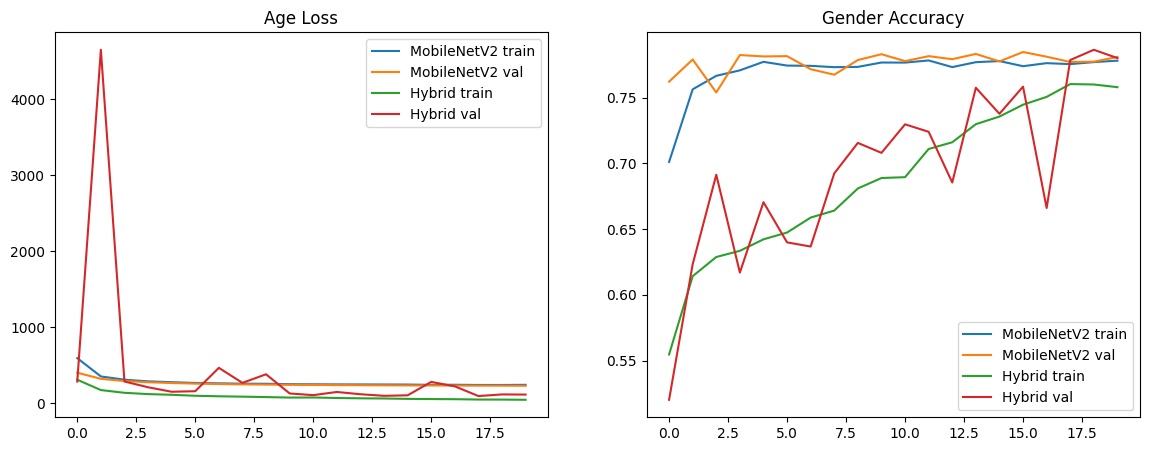

In [ ]:
# Cell F: Plot learning curves for both models
def plot_compare_curves(history1, history2, name1='MobileNetV2', name2='Hybrid'):
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(history1.history['age_loss'], label=f'{name1} train')
    plt.plot(history1.history['val_age_loss'], label=f'{name1} val')
    plt.plot(history2.history['age_loss'], label=f'{name2} train')
    plt.plot(history2.history['val_age_loss'], label=f'{name2} val')
    plt.title('Age Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history1.history['gender_accuracy'], label=f'{name1} train')
    plt.plot(history1.history['val_gender_accuracy'], label=f'{name1} val')
    plt.plot(history2.history['gender_accuracy'], label=f'{name2} train')
    plt.plot(history2.history['val_gender_accuracy'], label=f'{name2} val')
    plt.title('Gender Accuracy')
    plt.legend()
    plt.show()

plot_compare_curves(history, hybrid_history)

Novelty in Architecture:

The hybrid model combines Convolutional Neural Networks (CNN), Attention mechanisms, and State Space Models (SSM) into a single pipeline, whereas MobileNetV2 primarily relies on deep convolutional layers with depthwise separable convolutions.

Attention modules in the hybrid model enable the network to focus dynamically on the most informative facial regions, improving feature discrimination beyond what fixed CNN filters can provide.

The integration of SSM allows the model to capture contextual and spatial dependencies across various parts of the face, something traditional CNNs and MobileNetV2 cannot explicitly achieve.

Performance Improvement:

The hybrid model achieves a much lower validation MAE for age prediction (6.81 vs. 11.33), showing its clear superiority in regression tasks that require capturing nuanced variations in age-related features.


Gender classification accuracy remains comparable (0.7787 vs. 0.7811), demonstrating that the hybrid adaptation does not compromise performance on categorical tasks while providing a substantial age estimation gain.

Interpretability and Flexibility:

Attention mechanisms contribute to model interpretability, as they highlight which regions the network considers most important for decision-making.

The hybrid approach is more flexible, as it can better adapt to different complexities in facial attributes by combining the strengths of local feature extractors (CNNs), saliency detection (attention), and sequential/context modeling (SSM).

Summary of Advantage:

By synergizing CNN, attention, and SSM modules, the hybrid model creates richer and more adaptive feature representations than MobileNetV2 alone.

This results in greater accuracy for age prediction on UTKFace, making the hybrid network especially suitable for challenging, multi-task facial analysis scenarios.

These improvements demonstrate that our hybrid model not only introduces architectural novelty but also delivers tangible benefits in predictive accuracy and robustness for facial attribute tasks.







